# follow on from plot_tide_crossings

but with higher resolution as that didnt work

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
from numpy import linalg as LA
from functools import reduce
import os
import sys
import time
import datetime as dt
import pandas as pd
import geopandas as gpd
import scipy as sp
from scipy import signal

from shapely.geometry import Point
from shapely.geometry import MultiPoint
import fiona


In [2]:
paths = glob.glob('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/INTERSECTIONS/tides*.pkl')
paths.sort()
paths

['/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/INTERSECTIONS/tides_10msample20mcluster.pkl',
 '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/INTERSECTIONS/tides_10msample_10mbuffer.pkl',
 '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/INTERSECTIONS/tides_10msample_20mbuffer.pkl',
 '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/INTERSECTIONS/tides_10msample_30mbuffer.pkl',
 '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/INTERSECTIONS/tides_10msample_40mbuffer.pkl',
 '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/INTERSECTIONS/tides_10msample_50mbuffer.pkl',
 '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/INTERSECTIONS/tides_10msample_50mbuffer_timediff.pkl',
 '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/INTERSECTIONS/tides_10msample_60mbuffer.pkl',
 '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/INTERSECTIONS/tides_10msample_8mbuffer.pkl',
 '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/INTERSECTIONS/tides_1msample_1mbuffer.pkl',
 '/Users/home/

## Plot different resolution and buffers

In [3]:
def plot_tides(i,paths):
    df = pd.read_pickle(paths[i])
    plt.figure(figsize=(15,7))
    plt.plot(df.Latitude,df.tide,'x')
    plt.grid()
    plt.xlabel('latitude')
    plt.ylabel('change in elevation')
    plt.title(os.path.splitext(os.path.split(paths[i])[1])[0])

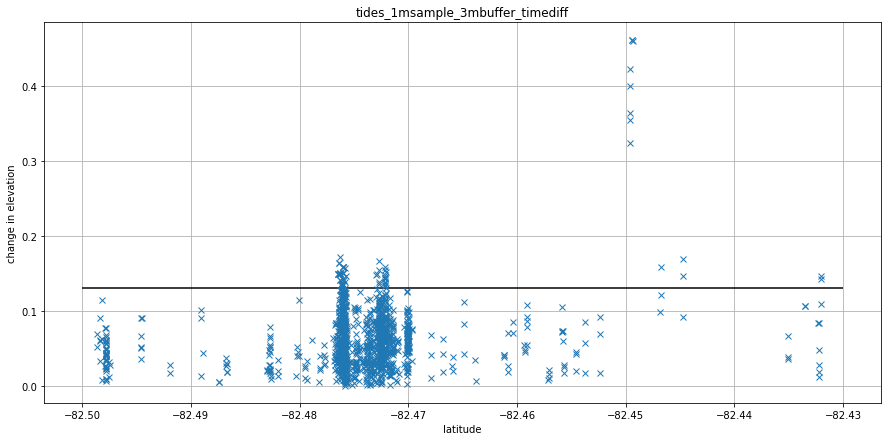

In [4]:
plot_tides(-1,paths)
plt.hlines(0.13,-82.5,-82.43)

# Draw a grounding line

This time trying to balance proximity with more points. So ill use the 1m sample, 3m buffer

NB the index on `tides_1msample_3mbuffer.pkl` is what i have called index1 in the past, ie it can be used to reference `radar_gnss_track_KIS2.shp`

In [5]:
df = pd.read_pickle('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/INTERSECTIONS/tides_1msample_3mbuffer.pkl')
tides_df = gpd.GeoDataFrame(df,geometry=df.geometry)

gdf = gpd.read_file('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/INTERSECTIONS/radar_gnss_track_KIS2.shp')

In [6]:
tides_df['grounded'] = tides_df.tide < 0.13

In [7]:
indicies_grounded = ( [val for sublist in tides_df[tides_df.grounded].intx_points.to_list() for val in sublist]
                     + tides_df[tides_df.grounded].index.to_list() )

indicies_float = ( [val for sublist in tides_df[~tides_df.grounded].intx_points.to_list() for val in sublist]
                     + tides_df[~tides_df.grounded].index.to_list() )

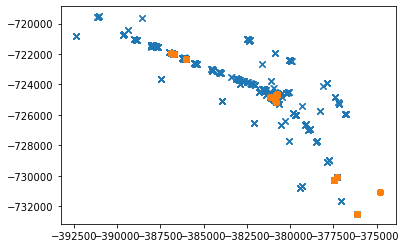

In [8]:
plt.plot(gdf.iloc[indicies_grounded].geometry.x,gdf.iloc[indicies_grounded].geometry.y,'x')
plt.plot(gdf.iloc[indicies_float].geometry.x,gdf.iloc[indicies_float].geometry.y,'o')
# plt.xlim([-382500,-379500])
# plt.ylim([ -726500,-724000])

In [12]:
floating_polygon = MultiPoint(gdf.iloc[indicies_float].geometry.to_list()).convex_hull

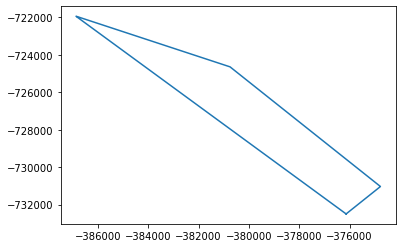

In [13]:
plt.plot(floating_polygon.exterior.xy[0],floating_polygon.exterior.xy[1])

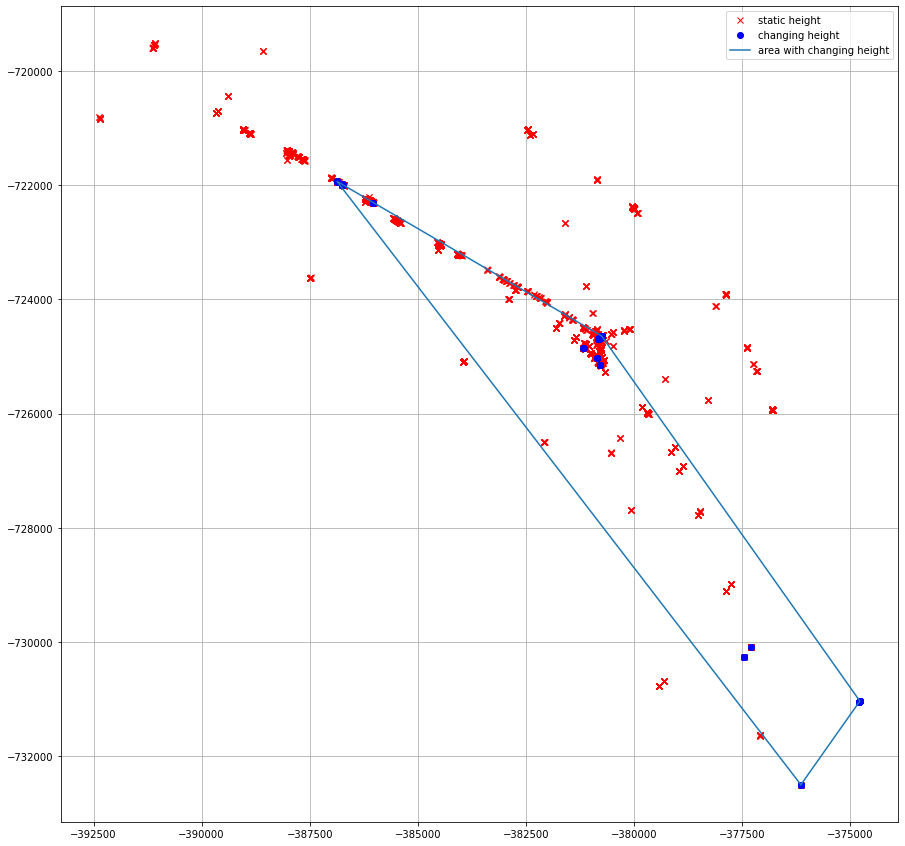

In [14]:
plt.figure(figsize=(15,15))
plt.plot(gdf.iloc[indicies_grounded].geometry.x,gdf.iloc[indicies_grounded].geometry.y,'rx')
plt.plot(gdf.iloc[indicies_float].geometry.x,gdf.iloc[indicies_float].geometry.y,'bo')
plt.plot(floating_polygon.exterior.xy[0],floating_polygon.exterior.xy[1])
plt.legend(['static height','changing height','area with changing height'])
plt.grid()

In [15]:
# plt.figure(figsize=(15,15))
# plt.plot(gdf.iloc[indicies_grounded].geometry.x,gdf.iloc[indicies_grounded].geometry.y,'rx')
# plt.plot(gdf.iloc[indicies_float].geometry.x,gdf.iloc[indicies_float].geometry.y,'bo')
# plt.plot(floating_polygon.exterior.xy[0],floating_polygon.exterior.xy[1])
# plt.legend(['static height','changing height','area with changing height'])
# plt.xlim([-386000,-379500])
# plt.ylim([ -726500,-724000])
# plt.grid()

In [16]:
aa = pd.DataFrame({'geometry': [floating_polygon]})
gpd.GeoDataFrame(aa,geometry=aa.geometry).to_file('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/INTERSECTIONS/polygon_float_1m_3m.shp')

# Plot floating area vs rema difference

rema difference notebook are at radarlines_over_rema_plots.ipynb

In [17]:
import rasterio as rio
df_rema = gpd.read_file('/Users/home/whitefar/DATA/REMOTE_SENSING/REMA_2m_strips/REMA_Strip_Index_Rel1.shp')
kis2 = [-380737.537026,-724683.311299]

In [18]:
def plot_REMA_diff(nid1,nid2,line_name,df=df,v=[0,10]):
    
    path = f"/Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/DIFFERENCES/REMA_{nid1}-{nid2}_diff.tif"
    image = rio.open(path)
    extent = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
    gdf = gpd.read_file("/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/"
                        +line_name+".shp")
    f = df.loc[nid1].acquisitio
    t =df.loc[nid2].acquisitio
    xmin,xmax = [gdf.geometry.x.to_numpy().min(),gdf.geometry.x.to_numpy().max()]
    ymin,ymax = [gdf.geometry.y.to_numpy().min(),gdf.geometry.y.to_numpy().max()]
    plt.figure(figsize=(15,14))
    plt.imshow(image.read(1),extent=extent, vmin=v[0],vmax=v[1])
    plt.xlim([xmin-1000, xmax])
    plt.ylim([ymin-1000,ymax])
    cb = plt.colorbar()
    plt.plot(gdf.geometry.x,gdf.geometry.y,'y')
    plt.plot(kis2[0],kis2[1],'y^')
    plt.title(f'REMA elevation change from {f} till {t}')
    cb.set_label('elevation change, m')
    

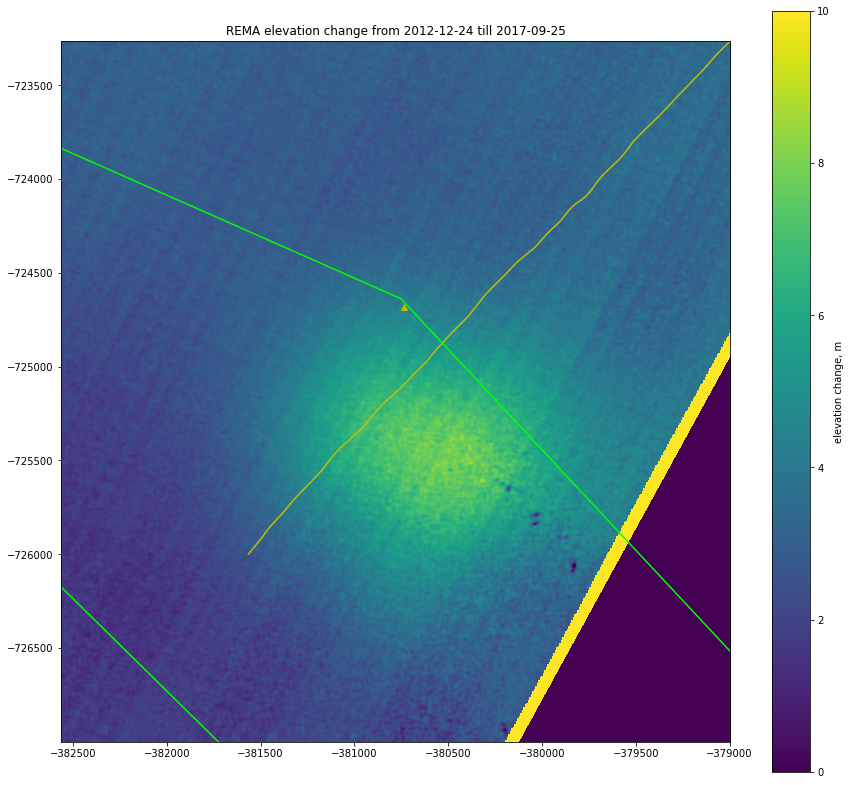

In [19]:

plot_REMA_diff(159202,145074,'line7',df=df_rema)
plt.plot(floating_polygon.exterior.xy[0],floating_polygon.exterior.xy[1],color='lime')


# Plot with time difference

Plot which part of the tidal cycle points were taken at to get max tide change

In [21]:
repeated = pd.read_pickle('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/INTERSECTIONS/tides_1msample_3mbuffer_timediff.pkl')
float_poly = gpd.read_file('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/INTERSECTIONS/polygon_float_1m_3m.shp')

In [29]:
# 0, 10 is same place in the tidal cycle, 5 is halfway through ie most different
repeated['tide_at']=(repeated.time_diff*10).round(0).astype(int).astype(str)
grounded = repeated[repeated.tide < 0.13]
floating = repeated[repeated.tide > 0.13]

In [30]:
float_poly.iloc[0].geometry.exterior.coords.xy[0]

array('d', [-376141.8892879574, -386867.0504097864, -386865.47670114733, -380753.66858792026, -380750.52202763595, -374779.3943898186, -374797.5580956906, -376140.3878146397, -376141.8892879574])

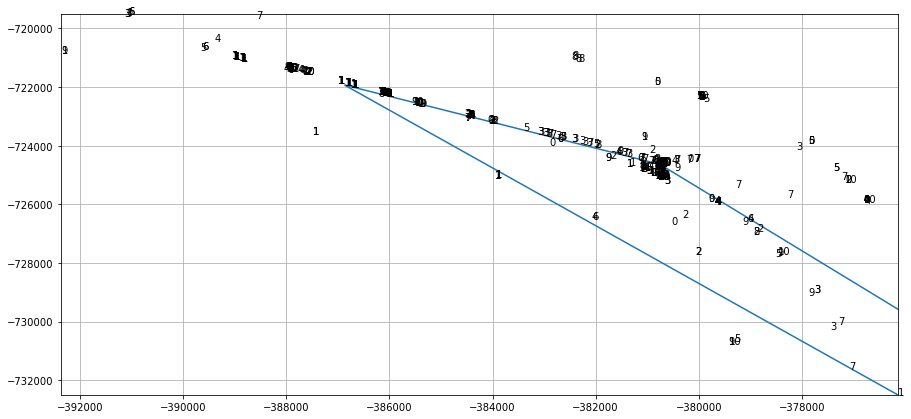

In [31]:
plt.figure(figsize=(15,7))
plt.plot(float_poly.iloc[0].geometry.exterior.coords.xy[0],float_poly.iloc[0].geometry.exterior.coords.xy[1])
plt.xlim([grounded.geometry.x.min(),grounded.geometry.x.max()])
plt.ylim([grounded.geometry.y.min(),grounded.geometry.y.max()])
plt.grid()

for i,row in grounded.iloc[::2].iterrows():
    plt.text(row.geometry.x,row.geometry.y,row.tide_at,fontsize=10)
    

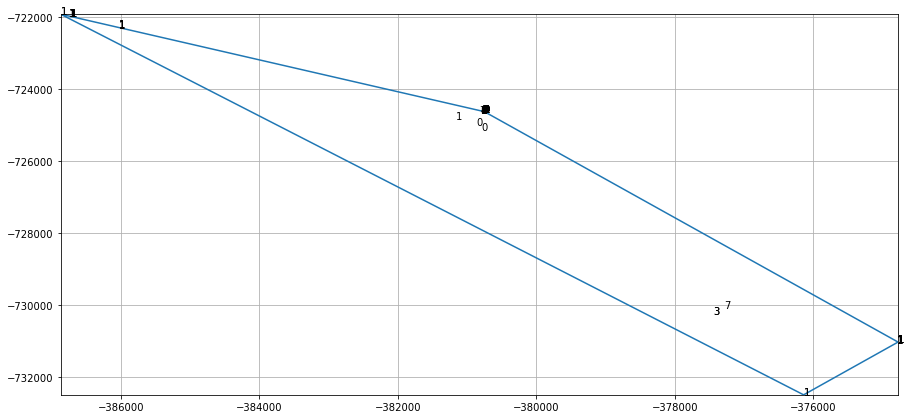

In [32]:
plt.figure(figsize=(15,7))
plt.plot(float_poly.iloc[0].geometry.exterior.coords.xy[0],float_poly.iloc[0].geometry.exterior.coords.xy[1])
plt.xlim([floating.geometry.x.min(),floating.geometry.x.max()])
plt.ylim([floating.geometry.y.min(),floating.geometry.y.max()])
plt.grid()

for i,row in floating.iterrows():
    plt.text(row.geometry.x,row.geometry.y,row.tide_at,fontsize=10)

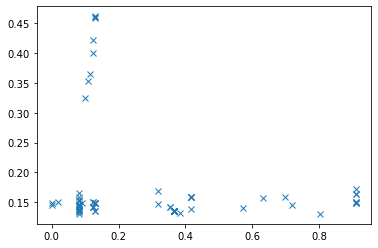

In [33]:
plt.plot(floating.time_diff,floating.tide,'x')

The above shows there is no correlation between height change and tide period time, and therefore this analysis is probably flawed.

Maybe try even higher resolution?

In [5]:
import sys 
print(sys.executable)

/Users/home/whitefar/miniconda3/envs/gis/bin/python


/bin/sh: 1: source: not found


In [ ]:

gdf = gpd.read_file('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/INTERSECTIONS/radar_gnss_track_KIS2.shp')
gdf.crs = "EPSG:3031"